In [1]:
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [4]:
import networkx as nx
from eppy.bunch_subclass import EpBunch
from geomeppy import IDF

from case_edits.ezcase import *
from helpers.ep_helpers import *
from helpers.ep_geom_helpers import *
from helpers.geometry_interfaces import *
from helpers.helpers import *
from plan.helpers import get_plans_from_file
from network.network2 import *
from network.visuals import *
from subsurfaces.logic import get_connecting_surface


In [5]:

inputs_dir = "case_red_d3"
outputs_dir = "tests/test22_svg2plan"

case = initialize_case(outputs_dir)
path_to_input = get_path_to_inputs(inputs_dir)
pairs = get_subsurface_pairs_from_case(path_to_input)




In [6]:
case = create_ezcase(outputs_dir, inputs_dir)
idf = case.idf

out.idf exists
IDF has changed: True


In [7]:
G, positions = create_graph_for_zone(idf, path_to_input)
G, positions  = add_cardinal_directions(G, positions)
G = add_edges(idf, G, pairs)
e_labels = create_edge_label_dict(idf, G)

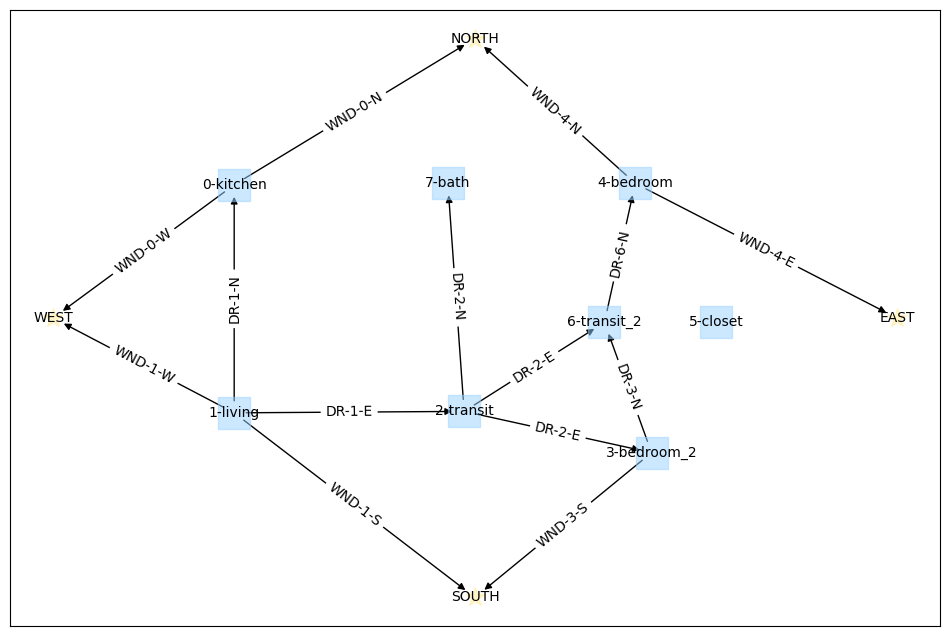

In [8]:
zone_nodes, cardinal_nodes = filter_nodes(G)

plt.figure(3,figsize=(12,8))
draw_graph_with_node_labels(G, positions, zone_nodes)
draw_graph_with_node_labels(G, positions, cardinal_nodes, color=CARDINAL_COLOR, shape="*", size=200)
draw_graph_edges_with_labels(G, positions, e_labels)

In [59]:
from typing import NamedTuple, TypedDict, Literal

class EdgeDetails(TypedDict):
    surface: str
    subsurfaces: str
    stype: Literal["WINDOW", "DOOR"]


class GraphEdge(NamedTuple):
    source: str
    target: str
    details: EdgeDetails

In [63]:
edges = list(G.edges(data=True))
# B0-Window-West 
edge = GraphEdge(*edges[0])
edge

GraphEdge(source='0-kitchen', target='WEST', details={'surface': 'Block 00 Storey 0 Wall 0003', 'subsurfaces': 'Block 00 Storey 0 Wall 0003 Window', 'stype': 'WINDOW'})

In [61]:
# def create_edge_label(G, edge: GraphEdge):
#     def map_ss_type(val):
#         d = {"DOOR": "DR", "WINDOW": "WND"}
#         return d[val]
#     def short_drn(name):
#         assert str(name)
#         return name[0]

#     owning_zone = G.nodes[edge.source]["num"]
#     type = map_ss_type(edge.details["stype"])
#     drn = get_surface_direction(idf, edge.details["surface"]).name
#     s_drn = short_drn(drn)

#     return f"{owning_zone}-{s_drn}-{type}"


In [66]:
nice_edges = [GraphEdge(*e) for e in G.edges(data=True)]

In [69]:
edge_label_dict = {(e.source, e.target):create_edge_label(idf, G, e) for e in nice_edges}

In [70]:
edge_label_dict

{('0-kitchen', 'WEST'): '0-W-WND',
 ('0-kitchen', 'NORTH'): '0-N-WND',
 ('1-living', '2-transit'): '1-E-DR',
 ('1-living', '0-kitchen'): '1-N-DR',
 ('1-living', 'WEST'): '1-W-WND',
 ('1-living', 'SOUTH'): '1-S-WND',
 ('2-transit', '6-transit_2'): '2-E-DR',
 ('2-transit', '3-bedroom_2'): '2-E-DR',
 ('2-transit', '7-bath'): '2-N-DR',
 ('3-bedroom_2', '6-transit_2'): '3-N-DR',
 ('3-bedroom_2', 'SOUTH'): '3-S-WND',
 ('4-bedroom', 'EAST'): '4-E-WND',
 ('4-bedroom', 'NORTH'): '4-N-WND',
 ('6-transit_2', '4-bedroom'): '6-N-DR'}

In [64]:
create_edge_label(G, edge)

'0-W-WND'